#Setting up the data

In [ ]:
!pip install mne
!pip install mne-icalabel

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.6/21.6 MB 33.8 MB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as plt
import os
import os.path as op
import mne
import numpy as np
import pandas as pd
from mne_icalabel import label_components
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score
import pywt

In [ ]:
eeg_channels =['P8',
 'T8',
 'CP6',
 'FC6',
 'F8',
 'F4',
 'C4',
 'P4',
 'AF4',
 'Fp2',
 'Fp1',
 'AF3',
 'Fz',
 'FC2',
 'Cz',
 'CP2',
 'PO3',
 'O1',
 'Oz',
 'O2',
 'PO4',
 'Pz',
 'CP1',
 'FC1',
 'P3',
 'C3',
 'F3',
 'F7',
 'FC5',
 'CP5',
 'T7',
 'P7']

In [ ]:
raw = mne.io.read_raw_edf('/content/P6.edf', preload=True, infer_types=True)
eeg_raw=raw.pick(mne.pick_channels(raw.info['ch_names'], include=eeg_channels))


Extracting EDF parameters from /content/P6.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 531499  =      0.000 ...  1062.998 secs...


/tmp/ipython-input-84-791337074.py:1: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf('/content/P6.edf', preload=True, infer_types=True)


In [ ]:
#Set Montage
montage = mne.channels.make_standard_montage('standard_1020')
eeg_raw.set_montage(montage)

<RawEDF | P6.edf, 32 x 531500 (1063.0 s), ~129.8 MiB, data loaded>

In [ ]:
events = mne.events_from_annotations(raw)
triggerTimeStamps = pd.DataFrame(events[0], columns=['Time Stamp', "", "Trigger"]).drop([""], axis = 1)
replaceDict = dict()
for i,j in events[1].items():
  replaceDict[j] = i.replace("Trigger#", "")
triggerTimeStamps.replace(replaceDict, inplace=True)
print("Triggers (With time stamps)\n", triggerTimeStamps)

Used Annotations descriptions: [np.str_('Trigger#100'), np.str_('Trigger#110'), np.str_('Trigger#200'), np.str_('Trigger#220'), np.str_('Trigger#301'), np.str_('Trigger#302'), np.str_('Trigger#303')]
Triggers (With time stamps)
      Time Stamp Trigger
0          3788     301
1          3819     220
2          4797     220
3          5795     220
4          6793     220
..          ...     ...
346      523657     200
347      524652     220
348      525652     220
349      526652     200
350      527131     100

[351 rows x 2 columns]


In [ ]:
triggerTimeStamps[(triggerTimeStamps['Trigger']=='220') & (triggerTimeStamps['Time Stamp'] < 199970)]

Time Stamp Trigger
1          3819     220
2          4797     220
3          5795     220
4          6793     220
5          7793     220
..          ...     ...
110      131437     220
111      132438     220
112      133442     220
115      135446     220
116      136446     220

[74 rows x 2 columns]

In [ ]:
bands = {'Delta (0-4 Hz)': (0, 4), 'Theta (4-8 Hz)': (4, 8),
         'Alpha (8-13 Hz)': (8, 13), 'Beta (13-32 Hz)': (13, 32),
         'Gamma (32-100 Hz)': (32, 100)}
i = 0
triggerTime = []
while i < len(triggerTimeStamps):
  if(triggerTimeStamps['Trigger'][i] in ['301', '302', '303']):
    print(f"Trigger Received: {triggerTimeStamps['Trigger'][i]} at time stamp {triggerTimeStamps['Time Stamp'][i]}")
    triggerTime.append([triggerTimeStamps['Trigger'][i], triggerTimeStamps['Time Stamp'][i]])
  i+=1

Trigger Received: 301 at time stamp 3788
Trigger Received: 302 at time stamp 52349
Trigger Received: 303 at time stamp 108434
Trigger Received: 302 at time stamp 199970
Trigger Received: 303 at time stamp 257637
Trigger Received: 301 at time stamp 305408
Trigger Received: 303 at time stamp 396827
Trigger Received: 301 at time stamp 443365
Trigger Received: 302 at time stamp 488649


In [ ]:
eeg_raw.notch_filter(50, p_value=0.001)
eeg_raw.filter(1.,100.)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1651 samples (3.302 s)



[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    0.6s finished


<RawEDF | P6.edf, 32 x 531500 (1063.0 s), ~129.8 MiB, data loaded>

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 4.096 (s)
Plotting power spectral density (dB=True).
Figure(1000x350)


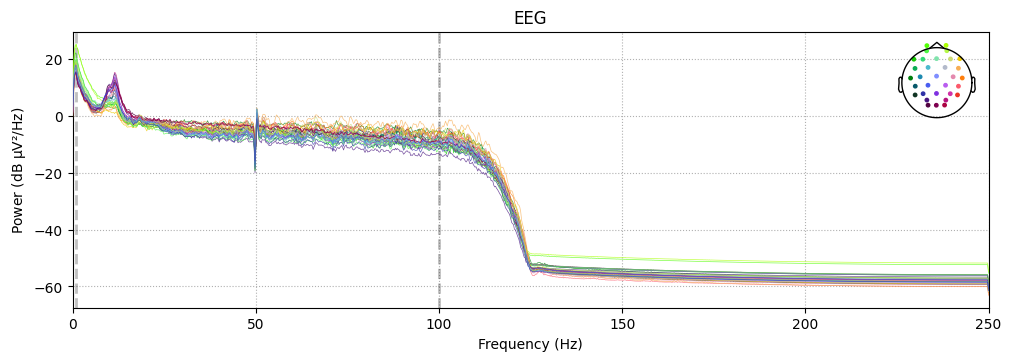

In [ ]:
print(eeg_raw.plot_psd())

<ICA | no decomposition, method: infomax>
Fitting ICA to data using 32 channels (please be patient, this may take a while)
    Rejecting  epoch based on EEG : ['Fp1']
Artifact detected in [15100, 15200]
Selecting by number: 18 components
Computing Extended Infomax ICA
Fitting ICA took 19.0s.
<ICA | raw data decomposition, method: infomax (fit in 500 iterations on 53000 samples), 18 ICA components (32 PCA components available), channel types: eeg, no sources marked for exclusion>


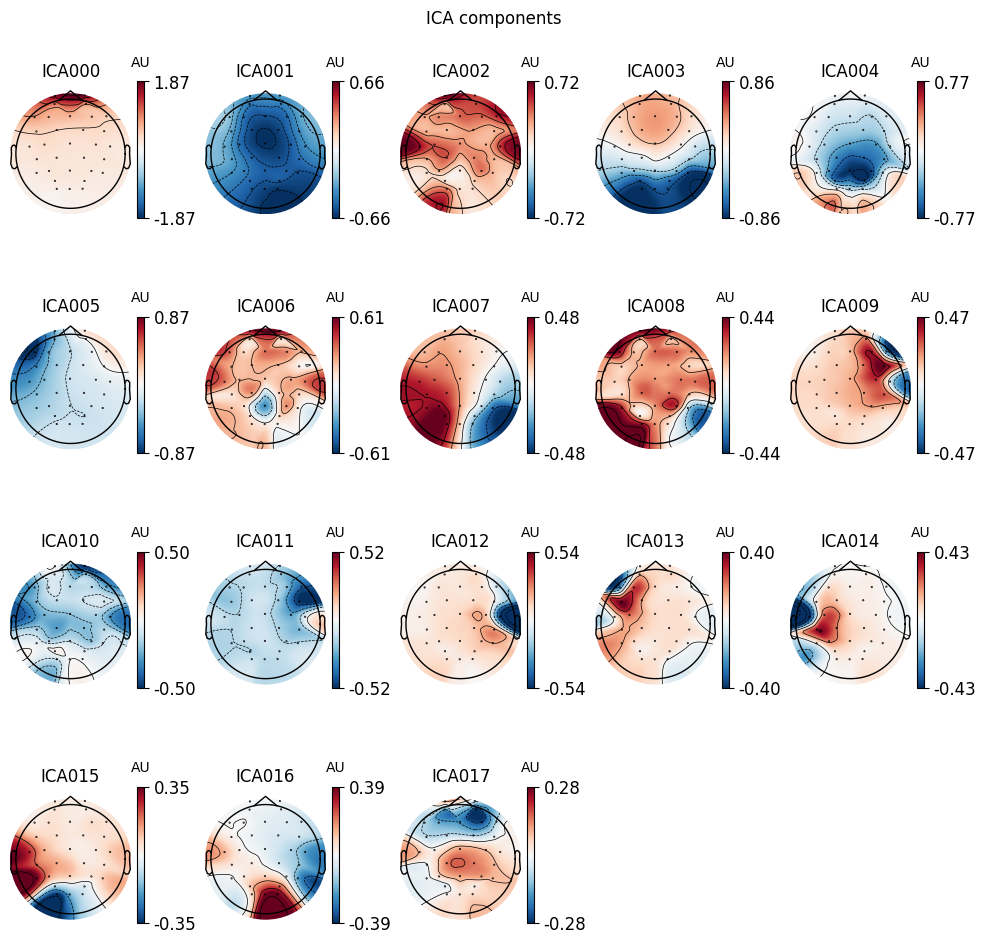

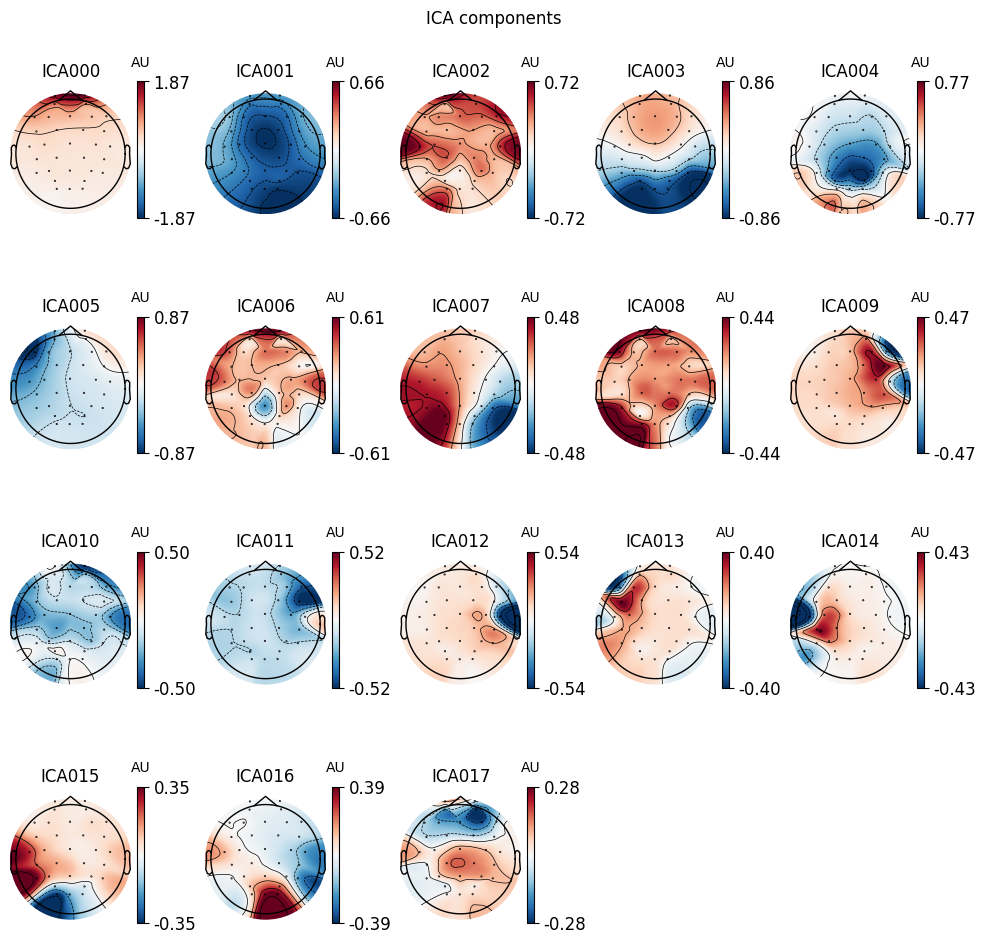

In [ ]:
#epochs1 = mne.read_epochs('/content/drive/MyDrive/combined_epochsnew.fif')
method = 'infomax'   # for comparison with EEGLAB try "extended-infomax" here
decim = 10  # we need sufficient statistics, not all time points -> saves time

random_state = 97

n_components = 18 # if float, select n_components by explained variance of PCA
ica = mne.preprocessing.ICA(n_components=n_components, method=method, random_state=random_state,fit_params=dict(extended=True))
print(ica)
reject = dict(eeg=450e-6)
ica.fit(eeg_raw,  decim=decim, reject=reject)
print(ica)
# ica.plot_properties(epochs, picks=0)
%matplotlib inline
# %matplotlib qt
ica.plot_components(colorbar=True)  # Plot all decomposed components

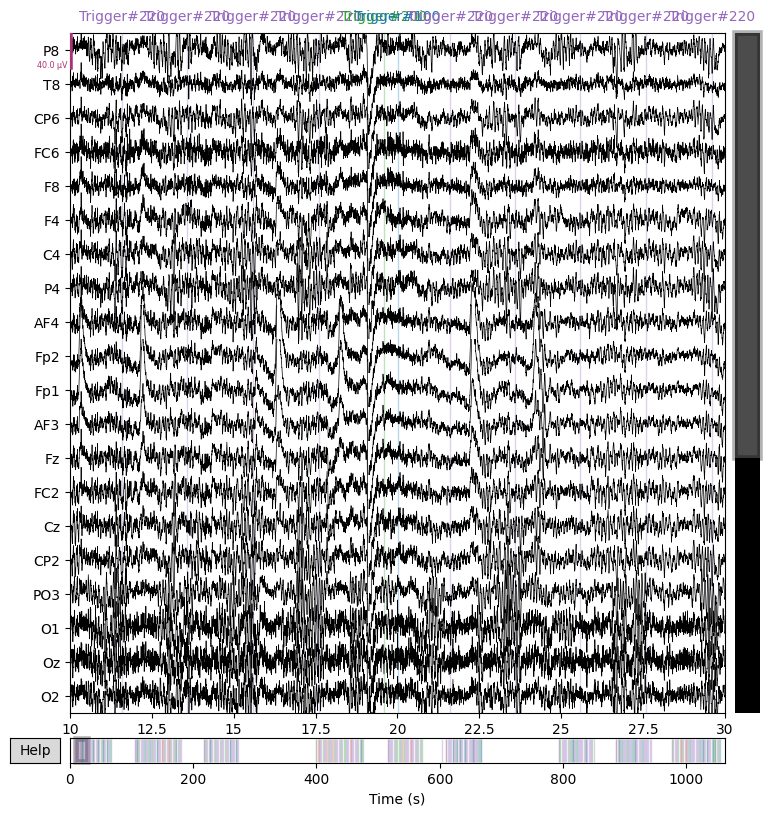

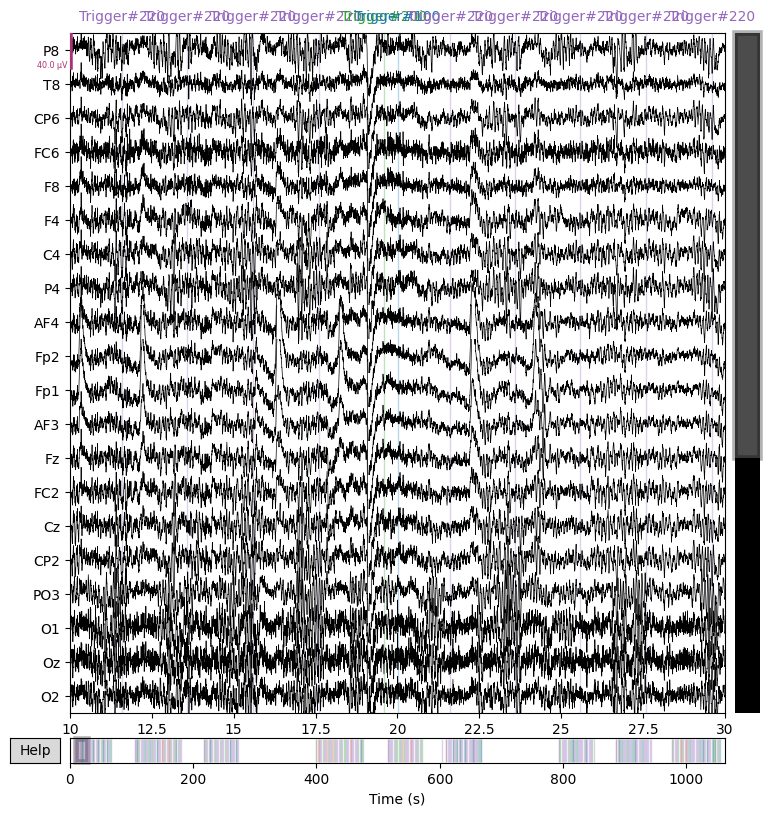

In [ ]:
eeg_raw.plot(start=10,duration=20)

Creating RawArray with float64 data, n_channels=18, n_times=531500
    Range : 0 ... 531499 =      0.000 ...  1062.998 secs
Ready.


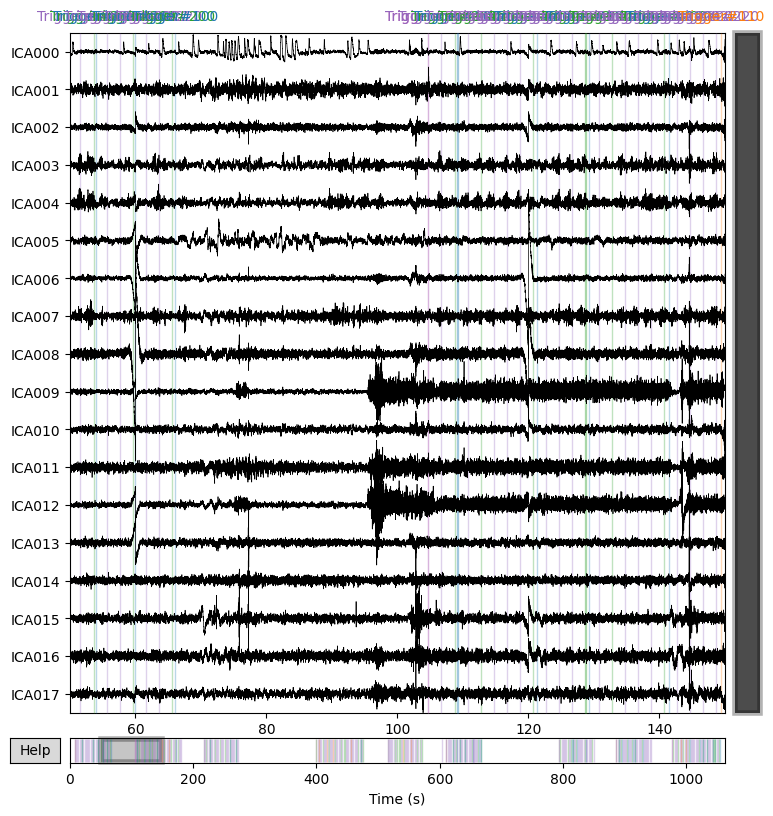

Figure(800x800)


In [ ]:
print(ica.plot_sources(eeg_raw,start=50,stop=150))

In [ ]:
ica.apply(eeg_raw,exclude= [0])

Applying ICA to Raw instance
    Transforming to ICA space (18 components)
    Zeroing out 1 ICA component
    Projecting back using 32 PCA components


<RawEDF | P6.edf, 32 x 531500 (1063.0 s), ~129.8 MiB, data loaded>

Creating RawArray with float64 data, n_channels=18, n_times=531500
    Range : 0 ... 531499 =      0.000 ...  1062.998 secs
Ready.


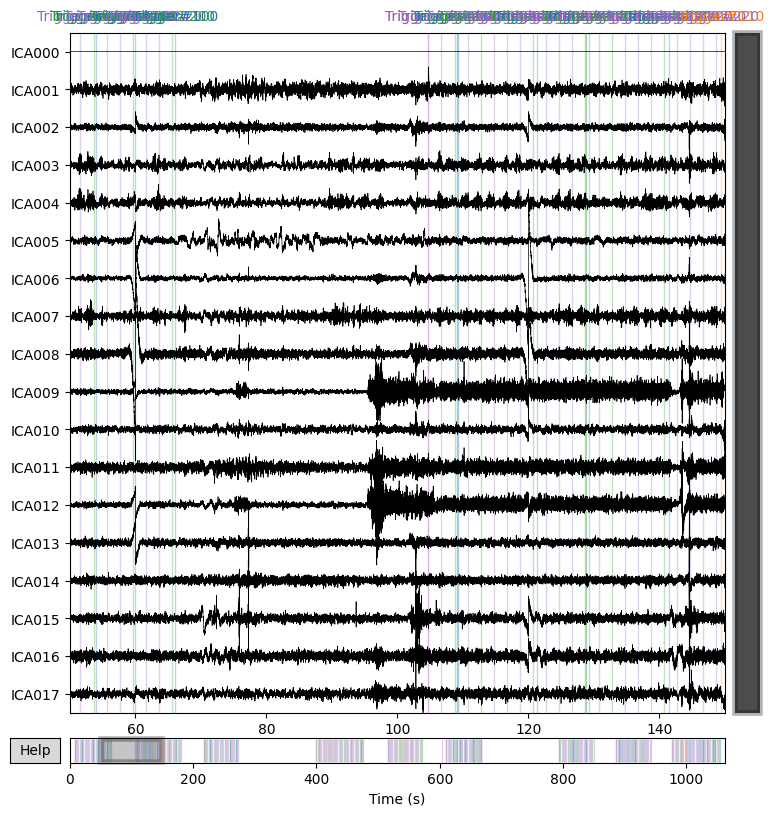

Figure(800x800)


In [ ]:
print(ica.plot_sources(eeg_raw,start=50,stop=150))


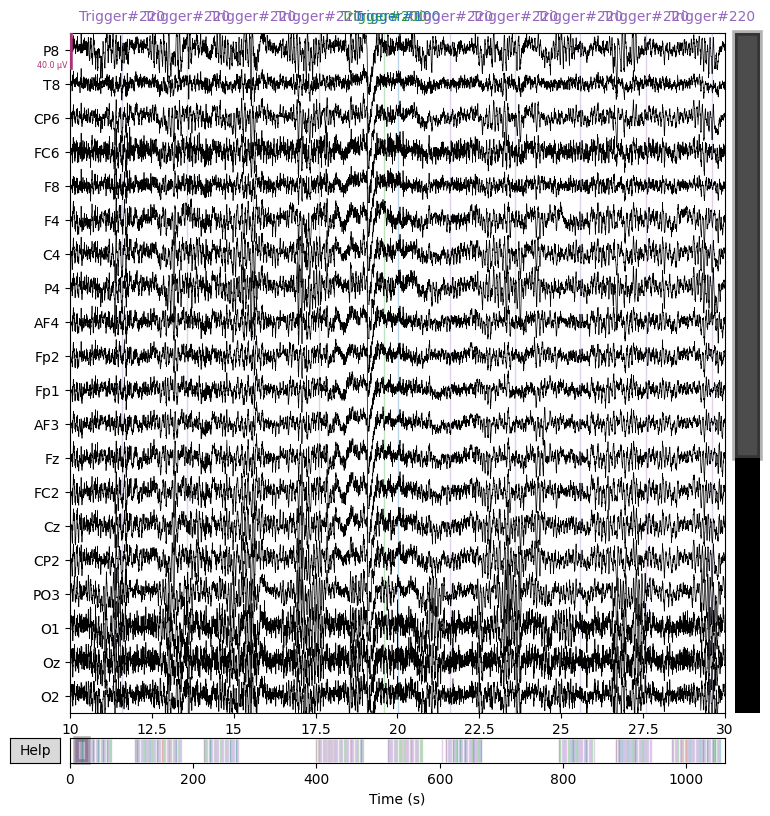

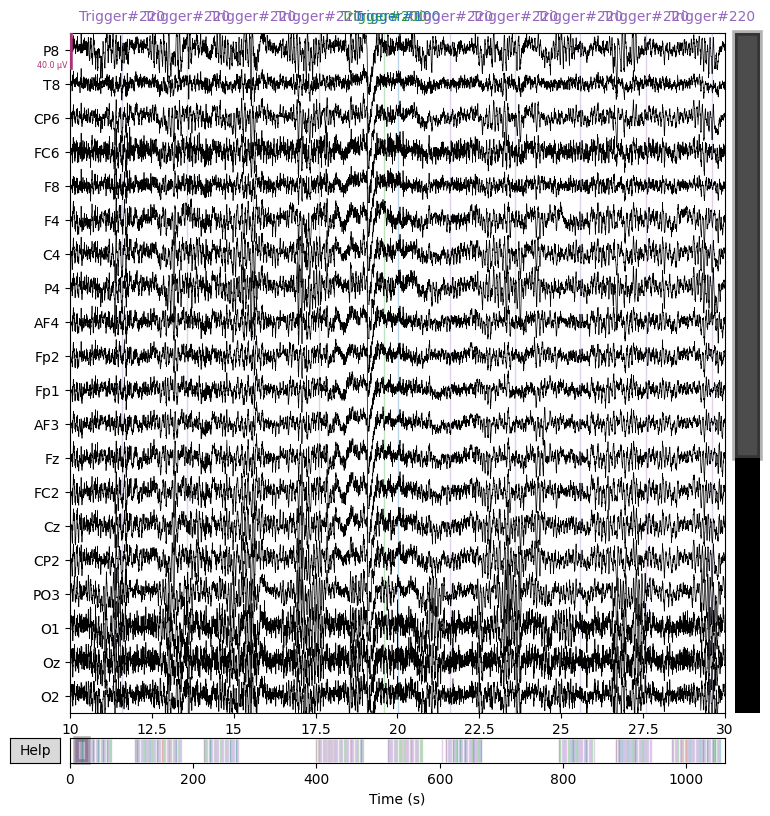

In [ ]:
eeg_raw.plot(start=10,duration=20)

#Channel Wise Spectrograms (with triggers)

###Zooming into the 1-back task + 30s break

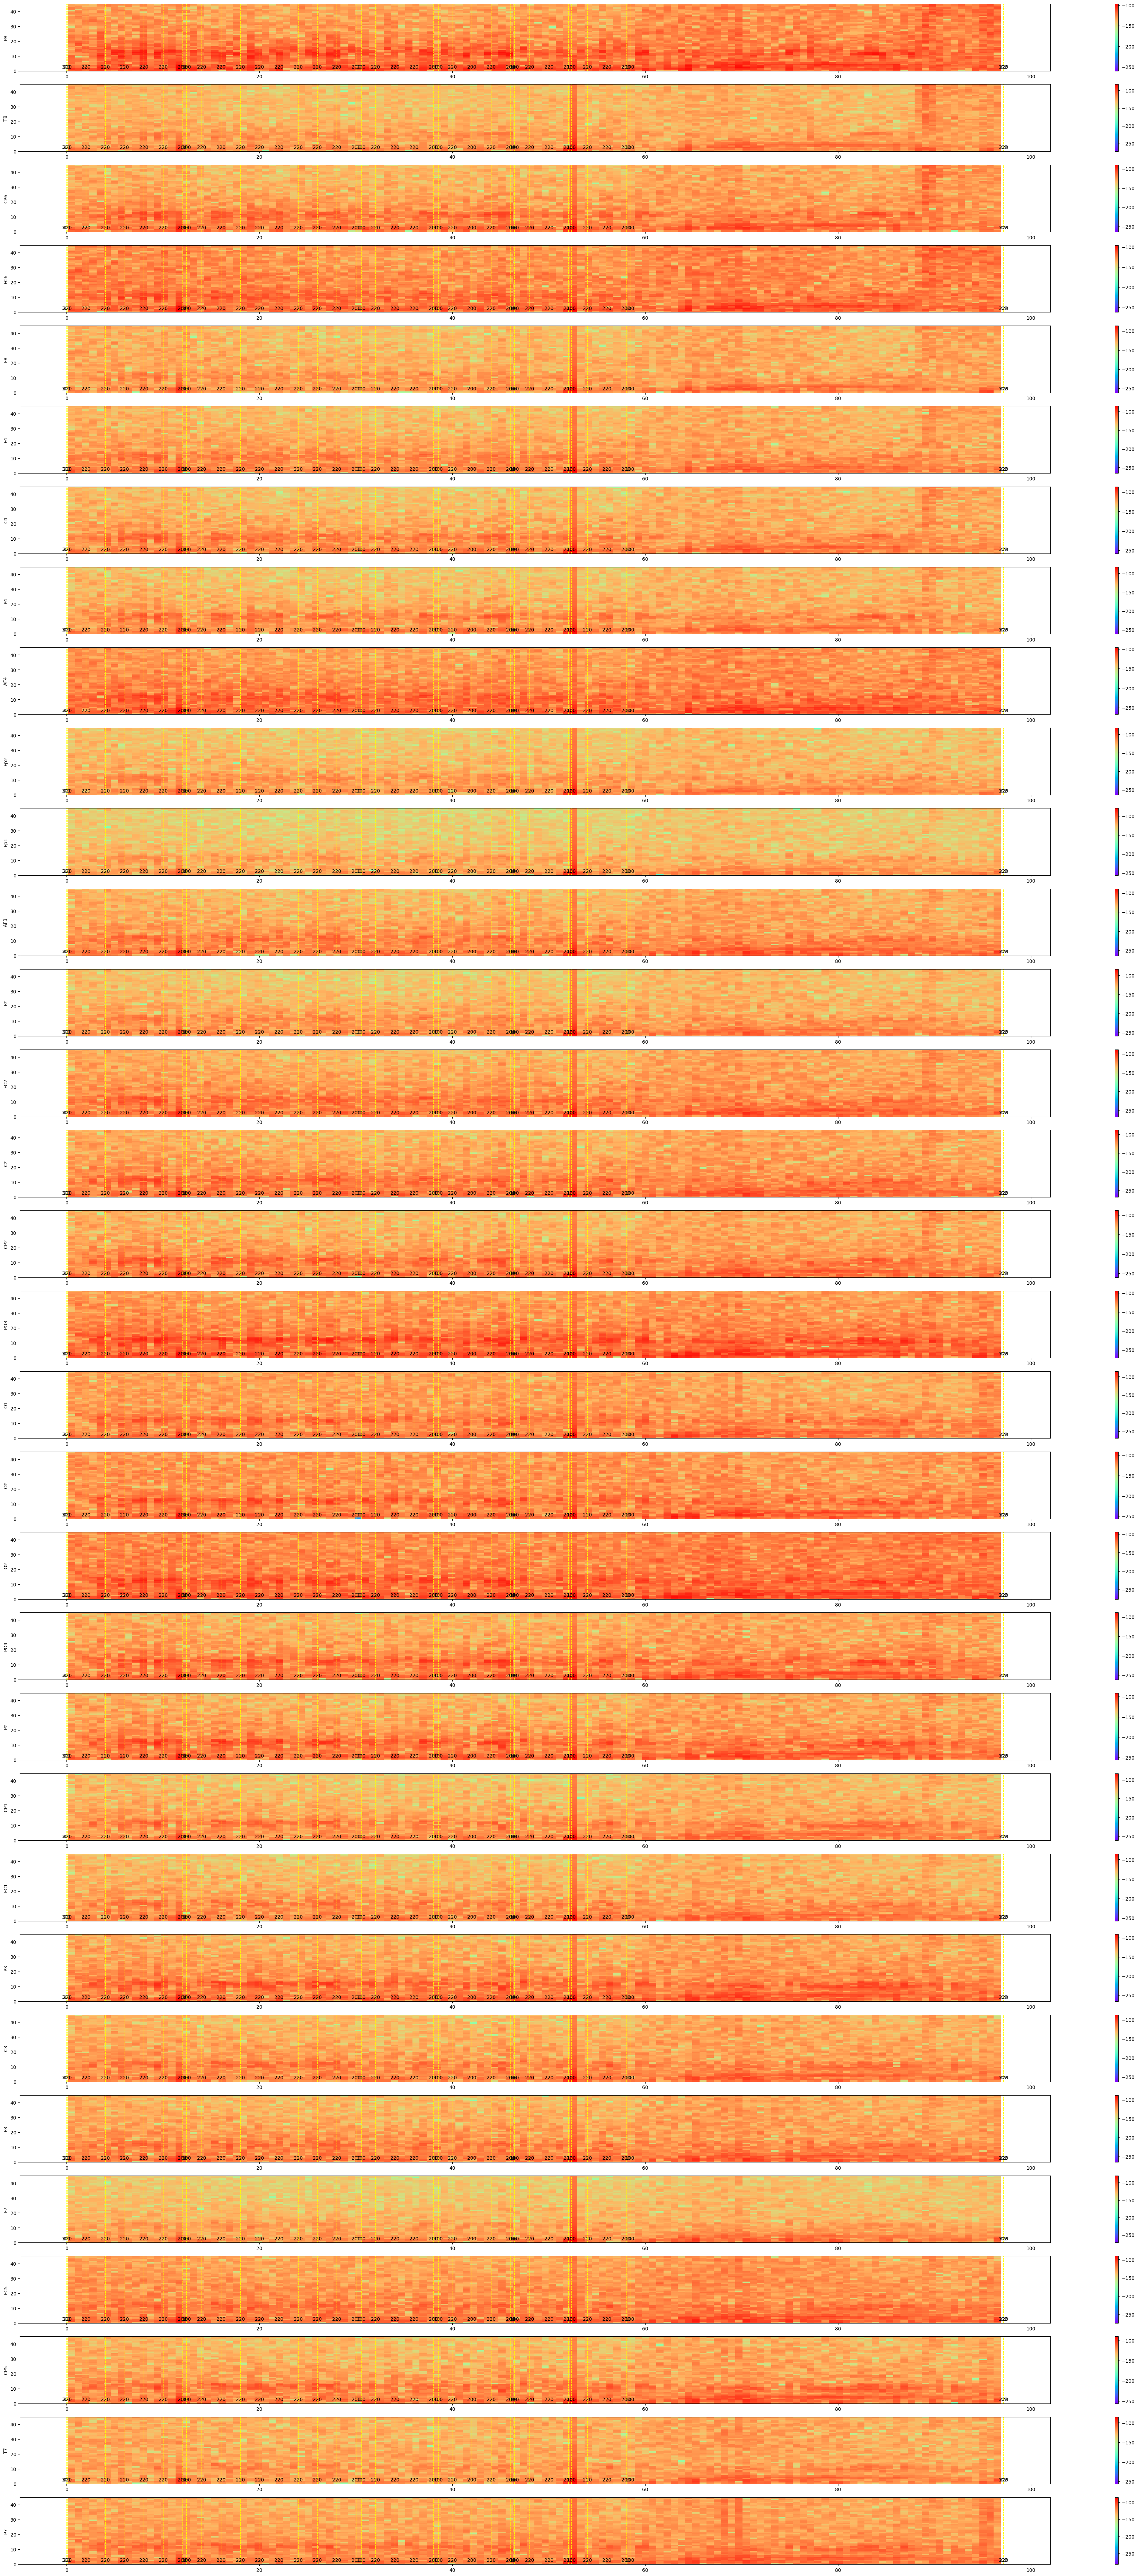

In [ ]:
figure = plt.figure(figsize=(48,96))

startTime = 3788
endTime = 52439
markersOn = 1
for i in range(32):
  ax = figure.add_subplot(32,1,i+1)
  if markersOn:
    time_positions = (np.array(triggerTimeStamps['Time Stamp'][(startTime <= triggerTimeStamps['Time Stamp']) & (triggerTimeStamps['Time Stamp'] < endTime)])-startTime)/500
    labels = list(triggerTimeStamps['Trigger'][(startTime <= triggerTimeStamps['Time Stamp']) & (triggerTimeStamps['Time Stamp'] < endTime)])
    for j in range(len(time_positions)):
        ax.axvline(x=time_positions[j], color='yellow', linestyle='--', linewidth=1)
        ax.text(time_positions[j], 1.02, labels[j], color='black', ha='center', va='bottom')
  plt.specgram(
    list(eeg_raw._data)[i][startTime:endTime],
    NFFT=500,
    Fs=500,
    noverlap=128,
    scale_by_freq=True,
    mode='psd',
    cmap='rainbow')
  plt.colorbar()
  plt.ylim(0, 45)
  plt.ylabel(f"{eeg_channels[i]}")
  # break